<h1> Lab Six: Convolutional Network Architectures </h1>

<h4> Adam Ashcraft, Maya Muralidhar, Nora Potenti, Michael Watts </h4>

<h1> 1.0 Business Understanding </h1>

This is a dataset of approximately 4,300 images of flowers. These images have been taken from Flickr, Google, and Yandax and are divided into five categories: dasies, dandelions, roses, sunflowers, and tulips.  The images are in standard definition quality and do not have a standardized size. According to the Kaggle page, the data was collected to answer the question, “What kind of flower is that?” The creator also includes a prediction task for the data on Kaggle, “You can use this dataset to recognize plants from the photo.” 

A flower identification tool would be useful for landscapers for several reasons. It could help them identify potential weeds that must be removed from gardens. It could also help them identify a flower so the landscaper can determine the best care instructions for the flower. It can even help a landscaper identify dangerous flowers he should avoid directly handling.

Another plant photo identification tool already exists in the market, Plantsnap. According to the Plantsnap website, it boasts a 96% success rate. In order for our tool to be considered viable, it must have at least, if not greater than, a 96% success rate.  

<hr>
Kaggle dataset: https://www.kaggle.com/alxmamaev/flowers-recognition <br>
Plantsnap self reported success rate: https://plantsnap.com/faq/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import glob
import pickle
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#use glob to get all file names in each folder
daisyFiles = glob.glob("flowers/daisy/*")
dandelionFiles = glob.glob("flowers/dandelion/*")
roseFiles = glob.glob("flowers/rose/*")
sunflowerFiles = glob.glob("flowers/sunflower/*")
tulipFiles = glob.glob("flowers/tulip/*")

daisies = []
dandelions = []
roses = []
sunflowers = []
tulips = []
#function to take image name, open image as numpy array and add to list
def addImageToArray(imageFileArray, imageArray):
    for file in imageFileArray:
        imageArray.append(np.asarray(Image.open(file)))
        
addImageToArray(daisyFiles,daisies)
addImageToArray(dandelionFiles,dandelions)
addImageToArray(roseFiles,roses)
addImageToArray(sunflowerFiles,sunflowers)
addImageToArray(tulipFiles,tulips)

C:\Users\mayam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


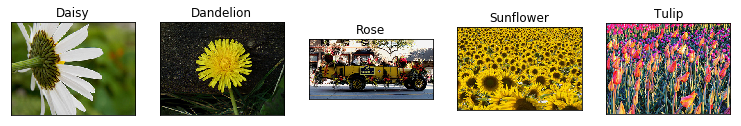

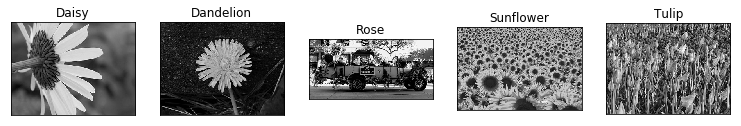

In [2]:
def displayImagesForTransform(images, titles):
    plt.figure(figsize=(1.7 * 6, 2.3 * 3))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(1 * 5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

displayImages = [Image.fromarray(daisies[0].astype('uint8'), 'RGB'),Image.fromarray(dandelions[0].astype('uint8'), 'RGB'),
                Image.fromarray(roses[0].astype('uint8'), 'RGB'), Image.fromarray(sunflowers[0].astype('uint8'), 'RGB'),
                 Image.fromarray(tulips[0].astype('uint8'), 'RGB')]
titles = ['Daisy','Dandelion','Rose','Sunflower','Tulip']
displayImagesForTransform(displayImages, titles)
def convertToGrayScale(RGBArray):
    return np.dot(RGBArray[...,:3], [0.3, 0.59, 0.11])
def convertAllImagesToGrey(ImageArray):
    for i in range (0, len(ImageArray)):
        ImageArray[i] = convertToGrayScale(ImageArray[i])
convertAllImagesToGrey(daisies)
convertAllImagesToGrey(dandelions)
convertAllImagesToGrey(roses)
convertAllImagesToGrey(sunflowers)
convertAllImagesToGrey(tulips)


displayImages = [Image.fromarray(daisies[0].astype('uint8'), mode='L'), Image.fromarray(dandelions[0].astype('uint8'), mode='L'),
                Image.fromarray(roses[0].astype('uint8'), mode='L'),Image.fromarray(sunflowers[0].astype('uint8'), mode='L'),
                Image.fromarray(tulips[0].astype('uint8'), mode='L')]
displayImagesForTransform(displayImages, titles)

In [3]:
def averageImageSize(imageArray):
    imgx = 0
    imgy = 0
    for img in imageArray:
        imgx += img.shape[0]
        imgy += img.shape[1]
    imgx /= len(imageArray)
    imgy /= len(imageArray)
    print(int(imgx),  " X ",  int(imgy))
print("\nDaisy Size:")
averageImageSize(daisies)
print("\nDandelion Size:")
averageImageSize(dandelions)
print("\nRose Size:")
averageImageSize(roses)
print("\nSunflower Size:")
averageImageSize(sunflowers)
print("\nTulip Size:")
averageImageSize(tulips)


Daisy Size:
252  X  331

Dandelion Size:
258  X  346

Rose Size:
244  X  327

Sunflower Size:
261  X  348

Tulip Size:
248  X  336


In [4]:
def matrixResize(arrayToAlter):
    croppedImages = []
    for i in range(0, len(arrayToAlter)):
        if(arrayToAlter[i].shape[0] >= 244 and arrayToAlter[i].shape[1] >= 327):
            #reload the matrix as an image
            image = Image.fromarray(arrayToAlter[i].astype('uint8'), mode='L')
            #crop the image by our calculations
            image.crop((0,0,244,327))
            #convert the image back into a matrix
            n = np.asarray(image)
            #final resize to ensure all matricies are the same size and remove any extra data from converting
            croppedImages.append( np.resize(n, (330,500)))
    return croppedImages

croppedDaisies = matrixResize(daisies)    

croppedDandelions = matrixResize(dandelions)    

croppedRoses = matrixResize(roses)    

croppedSunflowers = matrixResize(sunflowers)    

croppedTulips = matrixResize(tulips)    
print("Total Images:")
print(len(croppedDaisies)+len(croppedDandelions) +len(croppedRoses) + len(croppedSunflowers) 
      + len(croppedTulips))

print("\nDaisy Size:")
averageImageSize(croppedDaisies)
print("\nDandelion Size:")
averageImageSize(croppedDandelions)
print("\nRose Size:")
averageImageSize(croppedRoses)
print("\nSunflower Size:")
averageImageSize(croppedSunflowers)
print("\nTulip Size:")
averageImageSize(croppedTulips)


Total Images:
1305

Daisy Size:
330  X  500

Dandelion Size:
330  X  500

Rose Size:
330  X  500

Sunflower Size:
330  X  500

Tulip Size:
330  X  500


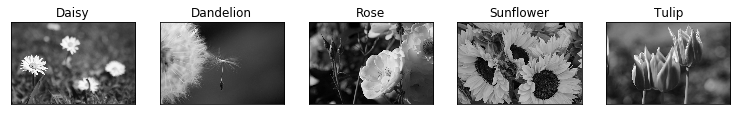

In [5]:
displayImages = [Image.fromarray(croppedDaisies[0].astype('uint8'), mode='L'), Image.fromarray(croppedDandelions[0].astype('uint8'), mode='L'),
                Image.fromarray(croppedRoses[0].astype('uint8'), mode='L'),Image.fromarray(croppedSunflowers[0].astype('uint8'), mode='L'),
                Image.fromarray(croppedTulips[0].astype('uint8'), mode='L')]
displayImagesForTransform(displayImages, titles)

In [6]:
def flattenMatrix(arrayOfMatracies):
    flattenedArray = []
    for m in arrayOfMatracies:
        flattenedArray.append(m.flatten())
        
    return flattenedArray
flatDaisy = flattenMatrix(croppedDaisies)
flatTulip = flattenMatrix(croppedTulips)
flatDandelions = flattenMatrix(croppedDandelions)
flatRoses = flattenMatrix(croppedRoses)
flatSunflowers = flattenMatrix(croppedSunflowers)
#combine the lists together
X = flatDaisy + flatTulip + flatDandelions + flatRoses + flatSunflowers
#example matrix to show only one dimension
print(flatSunflowers[0] )   

[ 4  9 17 ... 96 91 90]


## Convolutional Neural Net

In [ ]:
y = np.array(len(flatDaisy)*[0] + len(flatTulip)*[1] + len(flatDandelions)*[2] + len(flatRoses)*[3] + len(flatSunflowers)*[4])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
NUM_CLASSES = 5 
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
print(len(X_train[0]))
cnn = Sequential()
cnn.add(Reshape((1,330,500), input_shape=(1,165000)))
cnn.add(Conv2D(filters=16, kernel_size= (100, 100), padding='same', input_shape=(1,330,500)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=1)

165000
Epoch 1/150
